# Causal ML, Uplift Modeling Part 1

## Import Libraries & Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k,qini_auc_score
from sklift.datasets import fetch_hillstrom # our dataset!
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.metrics import roc_auc_score, log_loss
from causalml.metrics import auuc_score
import seaborn as sns

In [2]:
# Load Hillstrom dataset
def load_hillstrom():
    dataset = fetch_hillstrom(target_col='visit')
    df = dataset.data
    # Segment has 3 options, womens email, mens email and no email, so we can create 'treatment' by choosing one of the two treatments here
    df['segment'] = dataset.treatment
    # There are 3 outcomes, visit, conversion and spend, we can choose one of them as our target
    df['visit'] = dataset.target
    print("Are there any null values in this dataframe?\n")
    print(df.isna().sum())
    print("\n\n\n")
    print("What does the dataframe look like? What datatypes are the features?\n")
    print(df.info())
    return df

df = load_hillstrom()

Are there any null values in this dataframe?

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64




What does the dataframe look like? What datatypes are the features?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64

## Explore Data

In [3]:
# The treatment
df['segment'].value_counts()

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

In [4]:
# Let's just use men's email first and create a treatment variable to 1/0 the treatment/control
df = df.loc[df['segment'].isin(['Mens E-Mail','No E-Mail'])]
df['treatment'] = df['segment'].map({'Mens E-Mail':1,'No E-Mail':0})
df['treatment'].value_counts(normalize=True)

treatment
1    0.500012
0    0.499988
Name: proportion, dtype: float64

In [5]:
# This dataset has visit, conversion, and revenue as the target variables, we are going to use visit as the target variable
df['target'] = df['visit'].copy()
df['target'].value_counts()

target
0    36457
1     6156
Name: count, dtype: int64

In [6]:
# Customer purchased mens merchandise in the past year
df['mens'].value_counts()

mens
1    23526
0    19087
Name: count, dtype: int64

In [7]:
# Customer purchased womens merchandise in the past year
df['womens'].value_counts()

womens
1    23417
0    19196
Name: count, dtype: int64

In [8]:
# Only a few customers purchased from both mens and womens merch in the past year
df.groupby(['mens','womens']).size()

mens  womens
0     1         19087
1     0         19196
      1          4330
dtype: int64

In [9]:
# segments for TTM spend
df['history_segment'].value_counts()

history_segment
1) $0 - $100        15336
2) $100 - $200       9527
3) $200 - $350       8134
4) $350 - $500       4221
5) $500 - $750       3249
6) $750 - $1,000     1266
7) $1,000 +           880
Name: count, dtype: int64

In [10]:
# Actual TTM spend
df['history'].describe()

count    42613.000000
mean       241.859315
std        256.574723
min         29.990000
25%         64.500000
50%        157.000000
75%        325.210000
max       3345.930000
Name: history, dtype: float64

In [11]:
# Months since last purchase
df['recency'].value_counts()

recency
1     5934
2     5074
10    5022
9     4330
3     3899
4     3406
6     3048
5     2985
7     2720
8     2337
11    2316
12    1542
Name: count, dtype: int64

In [12]:
# New custome in past year
df['newbie'].value_counts()

newbie
1    21381
0    21232
Name: count, dtype: int64

In [13]:
# TTM purchase channels - must be an old dataset given the phone count
df['channel'].value_counts()

channel
Web             18863
Phone           18567
Multichannel     5183
Name: count, dtype: int64

In [14]:
# Classifies urban rural and suburban
df['zip_code'].value_counts()

zip_code
Surburban    19126
Urban        17105
Rural         6382
Name: count, dtype: int64

In [15]:
# Binarize the zip code and channel variables
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['channel'], drop_first=True, dtype=int)  # Encode categorical variable
df = df.drop(columns=['history_segment','segment','visit']) # Drop unnecessary features

In [16]:
# One grand view of our final dataset! Looks ready for modeling.
df.head()

,recency,history,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
1,6,329.08,1,1,1,0,0,0,0,0,1
3,9,675.83,1,0,1,1,0,0,0,0,1
8,9,675.07,1,1,1,1,0,0,0,1,0
13,2,101.64,0,1,0,1,1,0,1,0,1
14,4,241.42,0,1,1,0,0,0,0,0,0


In [17]:
# It appears everything is just about equal in terms of the treatment group and the control group for feature means, except the target which is ok
df.groupby('treatment').mean()

# Even if it wasn't, we could still run the model using the covariates as features, but would need to adjust for the imbalance in the treatment groups

,recency,history,mens,womens,newbie,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
treatment,,,,,,,,,,
0,5.749695,240.882653,0.553224,0.547639,0.501971,0.106167,0.451751,0.400920,0.437764,0.439923
1,5.773642,242.835931,0.550946,0.551415,0.501525,0.182757,0.445910,0.401887,0.433660,0.445394


## Feature Engineering to improve model

In [51]:
df.head()

,recency,history,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
1,6,329.08,1,1,1,0,0,0,0,0,1
3,9,675.83,1,0,1,1,0,0,0,0,1
8,9,675.07,1,1,1,1,0,0,0,1,0
13,2,101.64,0,1,0,1,1,0,1,0,1
14,4,241.42,0,1,1,0,0,0,0,0,0


In [56]:
for i in df.columns.to_list():
    print(df.groupby(['treatment','target']).agg({i:'mean'}))

                   recency
treatment target          
0         0       5.849874
          1       4.906278
1         0       5.906736
          1       5.178480
                     history
treatment target            
0         0       235.229693
          1       288.475482
1         0       234.395038
          1       280.581505
                      mens
treatment target          
0         0       0.548047
          1       0.596817
1         0       0.541951
          1       0.591166
                    womens
treatment target          
0         0       0.544423
          1       0.574713
1         0       0.543847
          1       0.585259
                    newbie
treatment target          
0         0       0.517328
          1       0.372679
1         0       0.519095
          1       0.422958
                  treatment
treatment target           
0         0             0.0
          1             0.0
1         0             1.0
          1             1.0
          

## Split Train Test Treatment

In [18]:
# Split data into train/test
def split_data(df):
    X = df.drop(columns=['treatment', 'target'])
    y = df['target']
    treatment = df['treatment']
    return train_test_split(X, y, treatment, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test, t_train, t_test = split_data(df)

## Run Two-Model and Single-Model Approaches

In [19]:
# Model Optimization with Optuna
def optimize_model(trial, X, y, model_type):
    # Set the hyperparameters to optimize and the ranges for xgboost
    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
        }
        model = XGBClassifier(**params, eval_metric='logloss')
        # Even though the eval metric for xgboost is logloss, we are evaluating the hyperparameters on maximizing AUC
    # Set the hyperparameters to optimize the ranges for random forest
    elif model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
        }
        model = RandomForestClassifier(**params, random_state=42)
    else:
        raise ValueError("Unsupported model type")

    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    return np.mean(scores)

In [20]:
# Run Optuna for Both Models
def run_optuna(X, y, model_type, model_seg, n_trials=50):
    # Create a study object to maximize the AUC
    study = optuna.create_study(direction='maximize')
    # optimize the study based on the input parameters
    study.optimize(lambda trial: optimize_model(trial, X, y, model_type), n_trials=n_trials)
    print(f"Best parameters for {model_type} for {model_seg}: {study.best_params}")
    return study.best_params

In [21]:
# Train and Evaluate Models
def train_and_evaluate(X_train, X_test, y_train, y_test, params, model_type, model_seg):
    # We'll look at xgboost and random forest, this is to train the final mdoel after optuna works it's magic
    if model_type == 'xgboost':
        model = XGBClassifier(**params,  eval_metric='logloss')
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**params, random_state=42)
    else:
        raise ValueError("Unsupported model type")

    # Fit the model and predict probabilities on the test dataset
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Grab the AUC & LogLoss metrics for the best model
    auc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    print(f"{model_type} AUC for {model_seg}: {auc:.4f}\n{model_type} Log Loss for {model_seg}: {logloss:.4f}")
    return model,y_pred

In [22]:
# Optimize and Train Separate Models for Two-Model Approach
def two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train):
    
    # Use function run_optuna to optimize the treatment model for xgboost and random forest adn return the optimal hyperparameters

    # Optimize treatment model for xgboost and random forest
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    params_treatment_xgboost = run_optuna(X_treatment, y_treatment, 'xgboost','treatment')
    params_treatment_randomforest = run_optuna(X_treatment, y_treatment, 'random_forest','treatment')

    # Optimize control model for xgboost and random forest
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    params_control_xgboost = run_optuna(X_control, y_control, 'xgboost','control')
    params_control_randomforest = run_optuna(X_control, y_control, 'random_forest','control')


    # Optimize single model for xgboost and random forest
    X_single_train = X_train.copy()
    X_single_train['treatment'] = t_train
    X_single_test_1 = X_test.copy()
    X_single_test_1['treatment'] = 1
    X_single_test_0 = X_test.copy()
    X_single_test_0['treatment'] = 0
    params_single_xgboost = run_optuna(X_single_train, y_train, 'xgboost','single')
    params_single_randomforest = run_optuna(X_single_train, y_train, 'random_forest','single')

    # Train final models using function train_and_evaluate
    model_treatment_xgboost,preds_treatment_xgboost = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_xgboost, 'xgboost','treatment')
    model_treatment_randomforest,preds_treatment_randomforest = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_randomforest, 'random_forest','treatment')
    model_control_xgboost,preds_control_xgboost = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_xgboost, 'xgboost','control')
    model_control_randomforest,preds_control_randomforest = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_randomforest, 'random_forest','control')
    model_single_1_xgboost,preds_single_1_xgboost = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_xgboost, 'xgboost','single_1')
    model_single_1_randomforest,preds_single_1_randomforest = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_randomforest, 'random_forest','single_1')
    model_single_0_xgboost,preds_single_0_xgboost = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_xgboost, 'xgboost','single_0')
    model_single_0_randomforest,preds_single_0_randomforest = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_randomforest, 'random_forest','single_0')

    return model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest

In [23]:
%%time
# Execute the Two-Model Approach with Optuna usng function "two_model_approach_with_optuna"
model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest = two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train)

[I 2024-12-25 13:12:10,039] A new study created in memory with name: no-name-946e918b-4f6d-423f-a155-6ea6d7ae1d07


[I 2024-12-25 13:12:12,125] Trial 0 finished with value: 0.5791443541901439 and parameters: {'n_estimators': 113, 'max_depth': 10, 'learning_rate': 0.13205100009051454, 'subsample': 0.9301100898842714, 'colsample_bytree': 0.8965340160991835, 'gamma': 0.5521337510835472}. Best is trial 0 with value: 0.5791443541901439.
[I 2024-12-25 13:12:12,734] Trial 1 finished with value: 0.6113616214806551 and parameters: {'n_estimators': 181, 'max_depth': 8, 'learning_rate': 0.026722963344520907, 'subsample': 0.7174897393629115, 'colsample_bytree': 0.6911736721621276, 'gamma': 2.6691471330547993}. Best is trial 1 with value: 0.6113616214806551.
[I 2024-12-25 13:12:13,125] Trial 2 finished with value: 0.6116319547458193 and parameters: {'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.014873339925677794, 'subsample': 0.6043598377382912, 'colsample_bytree': 0.7034117800765782, 'gamma': 2.6644171599390742}. Best is trial 2 with value: 0.6116319547458193.
[I 2024-12-25 13:12:14,077] Trial 3 finis

Best parameters for xgboost for treatment: {'n_estimators': 258, 'max_depth': 4, 'learning_rate': 0.13764396360415318, 'subsample': 0.6348576674371512, 'colsample_bytree': 0.6347090841976748, 'gamma': 4.997017043879158}


[I 2024-12-25 13:12:47,383] Trial 0 finished with value: 0.5836997911750474 and parameters: {'n_estimators': 256, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.6183467918375942}. Best is trial 0 with value: 0.5836997911750474.
[I 2024-12-25 13:12:48,969] Trial 1 finished with value: 0.5967157773897821 and parameters: {'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6150816797895859}. Best is trial 1 with value: 0.5967157773897821.
[I 2024-12-25 13:12:55,424] Trial 2 finished with value: 0.5655374321517578 and parameters: {'n_estimators': 114, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.9864136237737671}. Best is trial 1 with value: 0.5967157773897821.
[I 2024-12-25 13:13:00,414] Trial 3 finished with value: 0.5842207322825833 and parameters: {'n_estimators': 111, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.997272567682626

Best parameters for random_forest for treatment: {'n_estimators': 178, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.6380904001834491}


[I 2024-12-25 13:16:23,498] Trial 0 finished with value: 0.6084599463569288 and parameters: {'n_estimators': 173, 'max_depth': 8, 'learning_rate': 0.20400203463013308, 'subsample': 0.8648943586128917, 'colsample_bytree': 0.7527711626857335, 'gamma': 0.7432186221639353}. Best is trial 0 with value: 0.6084599463569288.
[I 2024-12-25 13:16:23,833] Trial 1 finished with value: 0.6341610057445509 and parameters: {'n_estimators': 154, 'max_depth': 6, 'learning_rate': 0.12043192228291452, 'subsample': 0.989898920845675, 'colsample_bytree': 0.9251485377249785, 'gamma': 2.7860160214631886}. Best is trial 1 with value: 0.6341610057445509.
[I 2024-12-25 13:16:24,163] Trial 2 finished with value: 0.6364362818904231 and parameters: {'n_estimators': 154, 'max_depth': 10, 'learning_rate': 0.2745702590145814, 'subsample': 0.9623873463774413, 'colsample_bytree': 0.7327323164778725, 'gamma': 3.5227666481221687}. Best is trial 2 with value: 0.6364362818904231.
[I 2024-12-25 13:16:25,130] Trial 3 finished

Best parameters for xgboost for control: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.015663596121076793, 'subsample': 0.6634459949622225, 'colsample_bytree': 0.8091622681433901, 'gamma': 2.0622307976522207}


[I 2024-12-25 13:17:02,461] Trial 0 finished with value: 0.6050326981452266 and parameters: {'n_estimators': 94, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.7091575480838636}. Best is trial 0 with value: 0.6050326981452266.
[I 2024-12-25 13:17:13,918] Trial 1 finished with value: 0.6037683252276116 and parameters: {'n_estimators': 246, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.9799780877844936}. Best is trial 0 with value: 0.6050326981452266.
[I 2024-12-25 13:17:19,334] Trial 2 finished with value: 0.6301047264074963 and parameters: {'n_estimators': 154, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 0.9722206647098338}. Best is trial 2 with value: 0.6301047264074963.
[I 2024-12-25 13:17:23,398] Trial 3 finished with value: 0.6079823293398009 and parameters: {'n_estimators': 97, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.8146553178400455}.

Best parameters for random_forest for control: {'n_estimators': 146, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.6290905962517259}


[I 2024-12-25 13:20:55,071] Trial 0 finished with value: 0.645773530467144 and parameters: {'n_estimators': 145, 'max_depth': 10, 'learning_rate': 0.02658005590053795, 'subsample': 0.6484646643182487, 'colsample_bytree': 0.6734932329564441, 'gamma': 1.188409386206537}. Best is trial 0 with value: 0.645773530467144.
[I 2024-12-25 13:20:56,083] Trial 1 finished with value: 0.653186827527072 and parameters: {'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.01061389987686953, 'subsample': 0.6161599365219582, 'colsample_bytree': 0.7950650181795175, 'gamma': 3.8812497420277574}. Best is trial 1 with value: 0.653186827527072.
[I 2024-12-25 13:20:56,799] Trial 2 finished with value: 0.649116115153113 and parameters: {'n_estimators': 208, 'max_depth': 6, 'learning_rate': 0.053308317432356284, 'subsample': 0.6263448658117967, 'colsample_bytree': 0.9886305821039414, 'gamma': 2.2178188361910083}. Best is trial 1 with value: 0.653186827527072.
[I 2024-12-25 13:20:57,295] Trial 3 finished wit

Best parameters for xgboost for single: {'n_estimators': 124, 'max_depth': 3, 'learning_rate': 0.21120815391636377, 'subsample': 0.7335613640215518, 'colsample_bytree': 0.6257225435308258, 'gamma': 2.5536063772176125}


[I 2024-12-25 13:21:32,555] Trial 0 finished with value: 0.6216541017433858 and parameters: {'n_estimators': 93, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.6626410729274074}. Best is trial 0 with value: 0.6216541017433858.
[I 2024-12-25 13:21:37,797] Trial 1 finished with value: 0.6374849142692011 and parameters: {'n_estimators': 143, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.896826348436867}. Best is trial 1 with value: 0.6374849142692011.
[I 2024-12-25 13:21:58,470] Trial 2 finished with value: 0.6076889344354434 and parameters: {'n_estimators': 168, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.9336860152492257}. Best is trial 1 with value: 0.6374849142692011.
[I 2024-12-25 13:22:16,164] Trial 3 finished with value: 0.6425137877600542 and parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.6653734212013477}.

Best parameters for random_forest for single: {'n_estimators': 242, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 0.6024265920185181}
xgboost AUC for treatment: 0.6240
xgboost Log Loss for treatment: 0.4090
random_forest AUC for treatment: 0.6186
random_forest Log Loss for treatment: 0.4105
xgboost AUC for control: 0.6198
xgboost Log Loss for control: 0.4142
random_forest AUC for control: 0.6169
random_forest Log Loss for control: 0.4156
xgboost AUC for single_1: 0.6231
xgboost Log Loss for single_1: 0.4091
random_forest AUC for single_1: 0.6193
random_forest Log Loss for single_1: 0.4103
xgboost AUC for single_0: 0.6214
xgboost Log Loss for single_0: 0.4138
random_forest AUC for single_0: 0.6143
random_forest Log Loss for single_0: 0.4157
CPU times: total: 40min 37s
Wall time: 21min 11s


In [24]:
# Uplift scores
def create_uplift_scores(preds_treatment_xgboost,
                        preds_control_xgboost,
                        preds_treatment_randomforest,
                        preds_control_randomforest,
                        preds_single_1_xgboost,
                        preds_single_1_randomforest,
                        preds_single_0_xgboost,
                        preds_single_0_randomforest):

    uplift_two_model_rf = preds_treatment_randomforest - preds_control_randomforest

    uplift_two_model_xg = preds_treatment_xgboost - preds_control_xgboost

    uplift_single_model_xg = preds_single_1_xgboost - preds_single_0_xgboost
    
    uplift_single_model_rf = preds_single_1_randomforest - preds_single_0_randomforest
    
    return uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf

uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf = create_uplift_scores(preds_treatment_xgboost,
                                                                                                                preds_control_xgboost,
                                                                                                                preds_treatment_randomforest,
                                                                                                                preds_control_randomforest,
                                                                                                                preds_single_1_xgboost,
                                                                                                                preds_single_1_randomforest,
                                                                                                                preds_single_0_xgboost,
                                                                                                                preds_single_0_randomforest
                                                                                                                )

## Compare Two-Model Approaches and Single-Model Approaches

### sklift Qini AUC Score

In [25]:
# Let's try sklift's qini auc score
qini_two_model_rf = qini_auc_score(y_test, uplift_two_model_rf, t_test)
qini_two_model_xg = qini_auc_score(y_test, uplift_two_model_xg, t_test)
qini_single_model_rf = qini_auc_score(y_test, uplift_single_model_rf, t_test)
qini_single_model_xg = qini_auc_score(y_test, uplift_single_model_xg, t_test)

comparison_df = pd.DataFrame({
    'Model': ['Two-Model RF', 'Two-Model XG', 'Single-Model RF', 'Single-Model XG'],
    'Qini Score': [qini_two_model_rf, qini_two_model_xg, qini_single_model_rf, qini_single_model_xg]
})
print("\n### Qini Score Comparison ###")
print(comparison_df)

# We can see initially that the XG, despite outperforming the RF on the individual models by a bit, does not outperform the random forest in the uplift model scenario
# The Two-Model RF beats out the single model RF by a little bit as well. Let's continue on.


### Qini Score Comparison ###
             Model  Qini Score
0     Two-Model RF    0.017310
1     Two-Model XG    0.006858
2  Single-Model RF    0.014760
3  Single-Model XG    0.012993


### Manual Qini Score

In [26]:
# Let's now try a manual calculation of the Qini Score
def calculate_uplift_metrics(df,uplift, n_groups=5):
    """
    Calculate common uplift model evaluation metrics.
    
    Parameters:
    y_true: array-like, actual outcome (visits)
    treatment: array-like, treatment indicator (0/1)
    uplift_scores: array-like, predicted uplift scores
    n_groups: int, number of groups for AUUC calculation
    
    Returns:
    dict with uplift metrics
    """
    # Sort by uplift scores
    df = df.sort_values(by=uplift, ascending=False)
    y_true = df['y_true'].values
    treatment = df['treatment'].values
    
    # Calculate cumulative gains
    n_samples = len(y_true)
    group_size = n_samples // n_groups
    
    gains = []
    for i in range(n_groups):
        start_idx = i * group_size
        end_idx = (i + 1) * group_size if i < n_groups - 1 else n_samples
        
        group_treat = treatment[start_idx:end_idx]
        group_outcome = y_true[start_idx:end_idx]
        
        # Calculate treatment and control response rates
        treat_rate = np.mean(group_outcome[group_treat == 1])
        ctrl_rate = np.mean(group_outcome[group_treat == 0])
        
        # Calculate uplift
        uplift = treat_rate - ctrl_rate
        gains.append(uplift)
    
    # Calculate metrics
    metrics = {
        'AUUC': np.trapz(gains) / len(gains),  # Area Under the Uplift Curve
        'Qini': np.sum(gains),  # Qini coefficient
        'top_group_uplift': gains[0],  # Uplift in highest scored group
        'uplift_by_group': gains
    }
    
    return metrics

In [27]:
# Create a dataframe with test results
results_df = pd.DataFrame({
    'y_true': y_test,               # Actual outcomes
    'treatment': t_test,            # Treatment indicators
    'uplift_tm_rf': uplift_two_model_rf,         # Uplift predictions from Random Forest
    'uplift_tm_xg': uplift_two_model_xg,        # Uplift predictions from XGBoost
    'uplift_sm_rf' : uplift_single_model_rf,
    'uplift_sm_xg' : uplift_single_model_xg
})
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg
493,0,0,0.069685,0.083539,0.073835,0.097123
21569,0,1,0.057508,0.070994,0.059944,0.058286
3531,0,0,0.098227,0.089518,0.088244,0.073780
50370,1,1,0.057569,0.075083,0.074855,0.081666
38375,0,1,0.040141,0.092262,0.069682,0.197698


In [28]:
xg_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_xg'
   )

rf_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_rf'
   )

xg_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_xg'
   )

rf_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_rf'
   )

In [29]:
print(rf_tm_metrics)
print(xg_tm_metrics)
print(rf_sm_metrics)
print(xg_sm_metrics)
# So here we are seeing the qini scores much higher and more similar.
# The XGBoost models win in this scenario
# For the AUUC, the RF wins for the TM but the XG wins for the SM

{'AUUC': 0.057219975208310445, 'Qini': 0.36783620154785457, 'top_group_uplift': 0.08893052647048016, 'uplift_by_group': [0.08893052647048016, 0.06642691728033523, 0.07664368548021701, 0.061292947774697654, 0.07454212454212453]}
{'AUUC': 0.05400162074339883, 'Qini': 0.3686553119270587, 'top_group_uplift': 0.11137305088741453, 'uplift_by_group': [0.11137305088741453, 0.041893530254601574, 0.06051481123179976, 0.06895255402052816, 0.08592136553271468]}
{'AUUC': 0.056109643547107804, 'Qini': 0.36805264539410015, 'top_group_uplift': 0.0909234513477522, 'uplift_by_group': [0.0909234513477522, 0.07932253604219262, 0.0570669896865927, 0.05665426434819244, 0.08408540396937021]}
{'AUUC': 0.058685036198826146, 'Qini': 0.36561553029207805, 'top_group_uplift': 0.08417034892299743, 'uplift_by_group': [0.08417034892299743, 0.0727964091808934, 0.06583982144551975, 0.08259860106977017, 0.06021034967289729]}


### CausalML AUUC Score

In [30]:
auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
    )
print(auuc_calc)
# Boy this a bummer, looks like the RF win in this case with the two model RF coming in first, but not much better than random, yikes.

uplift_tm_rf    0.529380
uplift_tm_xg    0.510113
uplift_sm_rf    0.526464
uplift_sm_xg    0.523055
Random          0.514123
dtype: float64


### Decile Chart?

In [31]:
results_df = results_df.sort_values(by='uplift_tm_rf', ascending=False)

In [32]:
results_df['decile_tm_rf'] = pd.qcut(results_df['uplift_tm_rf'], 10, labels=False, duplicates='drop', ) + 1


In [33]:
def calculate_uplift(df):
    treated = df[df['treatment'] == 1]['y_true'].mean()
    control = df[df['treatment'] == 0]['y_true'].mean()
    return treated - control

# Group by decile and calculate observed uplift
decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')

C:\Users\wallj\AppData\Local\Temp\ipykernel_22012\3131367042.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')


C:\Users\wallj\AppData\Local\Temp\ipykernel_22012\1261464934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')


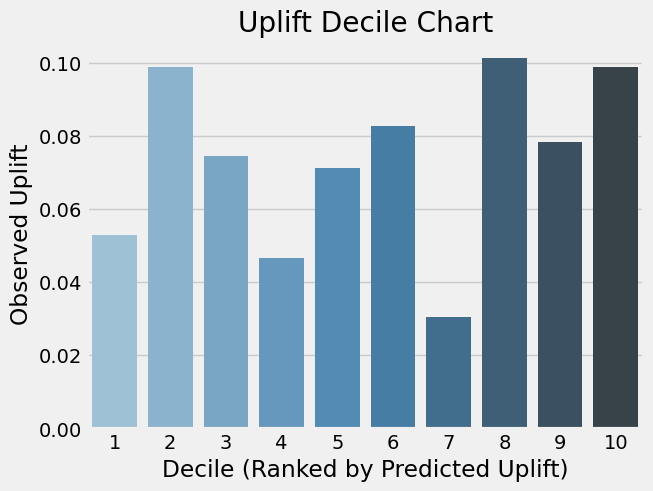

In [34]:
# Plot the observed uplift by decile
sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')
plt.title('Uplift Decile Chart')
plt.xlabel('Decile (Ranked by Predicted Uplift)')
plt.ylabel('Observed Uplift')
plt.show()

This is terrible

### Fake Qini Curve

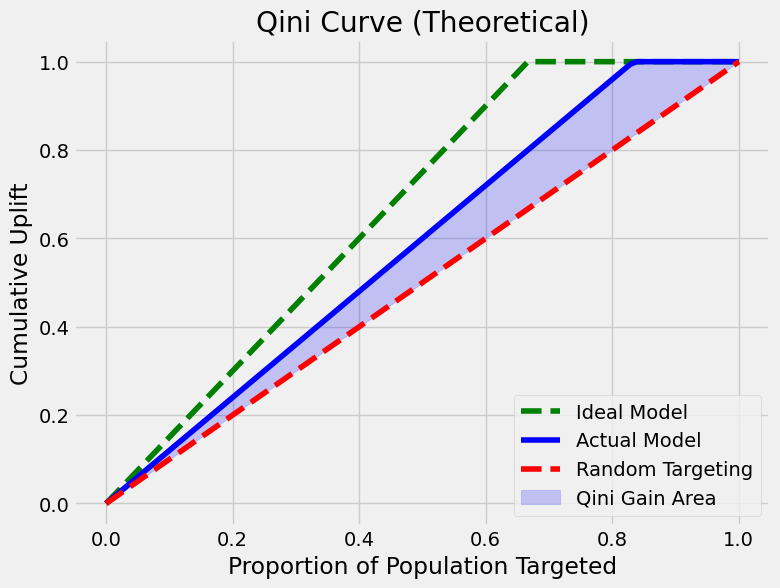

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Create data for a Qini curve
population_targeted = np.linspace(0, 1, 100)  # Proportion of population targeted (X-axis)
random_gain = population_targeted  # Baseline (random targeting)
ideal_gain = np.minimum(population_targeted * 1.5, 1.0)  # Ideal model (optimistic upper bound)
model_gain = np.minimum(population_targeted * 1.2, 1.0)  # Typical uplift model

# Plot the Qini curve
plt.figure(figsize=(8, 6))
plt.plot(population_targeted, ideal_gain, label="Ideal Model", linestyle="--", color="green")
plt.plot(population_targeted, model_gain, label="Actual Model", color="blue")
plt.plot(population_targeted, random_gain, label="Random Targeting", linestyle="--", color="red")
plt.fill_between(population_targeted, random_gain, model_gain, color="blue", alpha=0.2, label="Qini Gain Area")

# Customize plot
plt.title("Qini Curve (Theoretical)")
plt.xlabel("Proportion of Population Targeted")
plt.ylabel("Cumulative Uplift")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Qini Curve from Kaggle

In [45]:
results_df['target_class'] = 0  # Initialize column
results_df.loc[(results_df['treatment'] == 0) & (results_df['y_true'] == 1), 'target_class'] = 1
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 0), 'target_class'] = 2
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 1), 'target_class'] = 3

In [46]:
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,decile_tm_rf,target_class
53911,0,1,0.168605,0.164706,0.145198,0.144070,10,2
29341,1,1,0.166645,0.164706,0.147890,0.144070,10,3
23099,1,1,0.166518,0.130085,0.140903,0.132513,10,3
19352,0,1,0.165870,0.150906,0.139332,0.138003,10,2
8025,0,0,0.163861,0.153306,0.144847,0.138467,10,0


In [47]:
def qini_rank(uplift: pd.DataFrame, uplift_score: str) -> pd.DataFrame:
    """Rank the data by the uplift score for a specific model."""
    ranked = uplift[['target_class', uplift_score]].copy()
    ranked.rename(columns={uplift_score: 'uplift_score'}, inplace=True)

    # Add proportion
    ranked['n'] = ranked['uplift_score'].rank(pct=True, ascending=False)

    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

In [48]:
def qini_eval(ranked: pd.DataFrame) -> pd.DataFrame:
    """Evaluate the uplift value with the QINI criterion."""
    uplift_model = ranked.copy()
    random_model = ranked.copy()

    # Calculate cumulative gains for treatment and control groups
    C = sum(ranked['target_class'] <= 1)  # Total control group
    T = sum(ranked['target_class'] >= 2)  # Total treatment group
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1, 'cr'] = 1
    ranked.loc[ranked.target_class == 3, 'tr'] = 1
    ranked['cr/c'] = ranked['cr'].cumsum() / C
    ranked['tr/t'] = ranked['tr'].cumsum() / T

    # Calculate uplift for the model and random targeting
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'], 5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1], 5)

    # Add q0 for initial point
    q0 = pd.DataFrame({'n': [0], 'uplift': [0], 'target_class': [None]})
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop=True)
    random_model = pd.concat([q0, random_model]).reset_index(drop=True)

    # Add model names and combine
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop=True)
    return merged


In [49]:
def qini_plot(merged: pd.DataFrame):
    """Plot QINI curves for multiple models."""
    sns.set_style('whitegrid')

    # Plot the data
    ax = sns.lineplot(
        x='n', y='uplift', hue='model', data=merged, style='model', palette='Set2'
    )

    # Customize plot settings
    plt.xlabel('Proportion Targeted', fontsize=15)
    plt.ylabel('Uplift', fontsize=15)
    plt.title('Qini Curves for Multiple Models', fontsize=16)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    plt.grid(True)
    plt.show()
    return ax

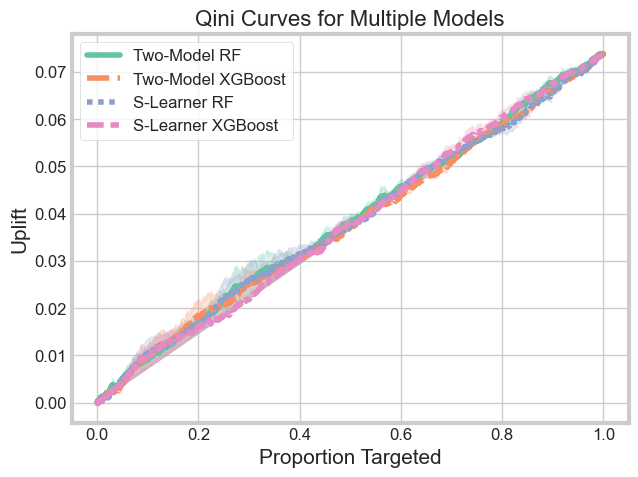

<Axes: title={'center': 'Qini Curves for Multiple Models'}, xlabel='Proportion Targeted', ylabel='Uplift'>

In [50]:
# Combine QINI results for all models
merged_results = pd.DataFrame()

# List of uplift columns for different models
uplift_columns = ['uplift_tm_rf', 'uplift_tm_xg', 'uplift_sm_rf', 'uplift_sm_xg']
model_names = ['Two-Model RF', 'Two-Model XGBoost', 'S-Learner RF', 'S-Learner XGBoost']

for uplift_score, model_name in zip(uplift_columns, model_names):
    ranked = qini_rank(results_df, uplift_score)
    merged = qini_eval(ranked)
    merged['model'] = model_name  # Add model name for identification
    merged_results = pd.concat([merged_results, merged], ignore_index=True)

# Plot all QINI curves
qini_plot(merged_results)